In [1]:
import pudl
import pandas as pd
import numpy as np

# Making Sense of the Zillion EIA Aggregates

In [3]:
import sqlalchemy as sa
pudl_settings = pudl.workspace.setup.get_defaults()
pudl_engine = sa.create_engine(pudl_settings["pudl_db"])

In [4]:
aggs = pd.read_sql_table('fuel_receipts_costs_aggs_eia', pudl_engine)

## What Aggregates are there?
The aggregates break down over 4 dimensions (+ `report_date`):
* fuel type
* geography
* sector
* time scale

In [5]:
aggs.columns

Index(['fuel_agg', 'geo_agg', 'sector_agg', 'temporal_agg', 'report_date', 'fuel_received_mmbtu', 'fuel_cost_per_mmbtu'], dtype='object')

In [6]:
dimensions = ['fuel_agg', 'geo_agg', 'sector_agg', 'temporal_agg']

### How Many?
There are over 6500 different aggregates, but most of them have few or zero values. Only 1568 (24%) have at least 50% coverage over time.

In [12]:
aggs.groupby(dimensions).ngroups

6517

In [18]:
aggs.query('fuel_cost_per_mmbtu.notnull()').groupby(dimensions).ngroups

2286

In [23]:
counts = aggs.groupby(dimensions)['fuel_cost_per_mmbtu'].agg(['size', 'count'])

array([[<AxesSubplot: title={'center': 'size'}>,
        <AxesSubplot: title={'center': 'count'}>]], dtype=object)

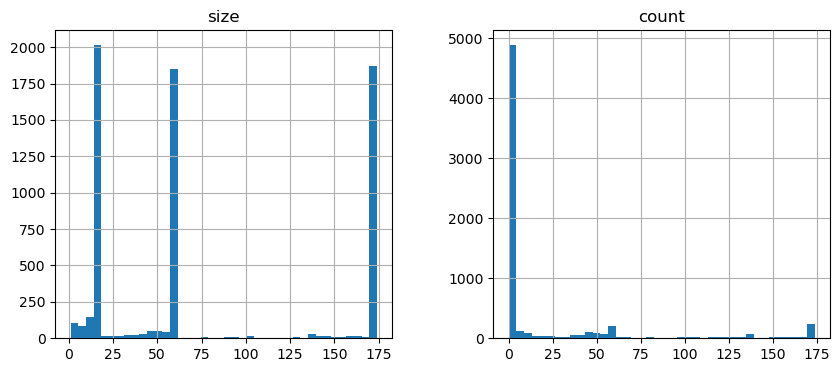

In [27]:
# peaks correspond to complete annual, quarterly, and monthly timeseries
counts.hist(bins=40, figsize=(10,4))

array([[<AxesSubplot: title={'center': 'size'}>,
        <AxesSubplot: title={'center': 'count'}>]], dtype=object)

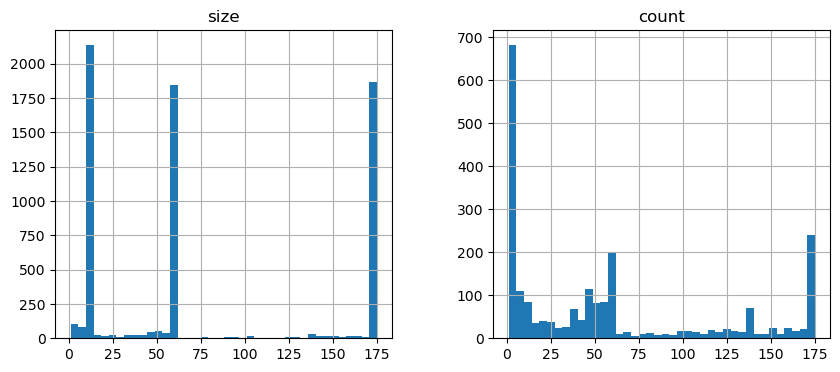

In [29]:
# remove completely empty aggregates
counts.hist(bins=40, figsize=(10,4), range=(1,175))

In [41]:
counts['count'].value_counts().nlargest(10)

0      4231
3       422
58      192
174     182
1       108
2        98
6        75
46       63
138      52
56       42
Name: count, dtype: int64

<AxesSubplot: >

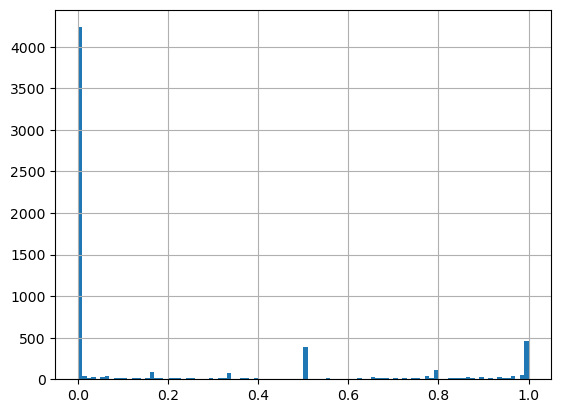

In [39]:
# weird that so many have exactly 50% coverage. I don't like that!
counts['count'].groupby('temporal_agg').transform(lambda x: x.div(x.max())).hist(bins=100)

In [32]:
counts['count'].groupby('temporal_agg').transform(lambda x: x.div(x.max())).ge(0.5).agg(['sum', 'mean'])

sum     1568.000000
mean       0.240602
Name: count, dtype: float64

### How Many Aggregates Involve a Single Fuel Price?
Theoretically there can be up to 72 aggregates involving a single fuel price:
* up to 4 sectoral levels (eg ipp_cogen, all_ipp, all_eletric_sector, all_sectors)
* up to 3 temporal levels (monthly, quarterly, annual)
* up to 2 fuel levels (eg BIT, all_coal)
* up to 3 geographic levels (state, census_region, national)

4\*3\*2\*3 = 72 

In [2]:
from pudl.metadata.dfs import (
    EIA_FUEL_AGGREGATE_ASSN,
    EIA_SECTOR_AGGREGATE_ASSN,
    POLITICAL_SUBDIVISIONS
)

In [33]:
EIA_FUEL_AGGREGATE_ASSN

,fuel_agg,energy_source_code_eia
0,bituminous_coal,BIT
1,sub_bituminous_coal,SUB
2,lignite_coal,LIG
3,all_coal,BIT
4,all_coal,SUB
5,all_coal,LIG
6,all_coal,WC
7,natural_gas,NG
8,petroleum_coke,PC
9,petroleum_liquids,DFO


In [34]:
EIA_FUEL_AGGREGATE_ASSN['energy_source_code_eia'].value_counts().max()

2

In [35]:
EIA_SECTOR_AGGREGATE_ASSN

,sector_agg,sector_id_eia
0,electric_utility,1
1,ipp_non_cogen,2
2,ipp_cogen,3
3,commercial_non_cogen,4
4,commercial_cogen,5
5,industrial_non_cogen,6
6,industrial_cogen,7
7,all_sectors,1
8,all_sectors,2
9,all_sectors,3


In [36]:
EIA_SECTOR_AGGREGATE_ASSN['sector_id_eia'].value_counts().max()

4

## Structuring for Imputation
I need to join aggregates to FRC index and convert to wide format so that each row is a single FRC fuel price with a vector of info needed for imputation. This will essentially add 72 additional columns to the FRC table - one for each possible aggregate. Many of those columns will be mostly NULL, but I'll deal with that later.

To do that I need to create associate tables between the aggregates and their components. It may also be useful to note the hierarchical structure of the aggregate categories.



### Sectoral Aggregate Associations

In [155]:
sectors = EIA_SECTOR_AGGREGATE_ASSN.sort_values('sector_id_eia')  # copy
map_sector_levels = { # some ambiguity about how to label electric_utility and all_electric_power
    "all_commercial": 2,
    "all_electric_power": 3,
    "all_industrial": 2,
    "all_ipp": 2,
    "all_sectors": 4,
    "commercial_cogen": 1,
    "commercial_non_cogen": 1,
    "electric_utility": 1,
    "industrial_cogen": 1,
    "industrial_non_cogen": 1,
    "ipp_cogen": 1,
    "ipp_non_cogen": 1,
}
sectors['sector_level'] = sectors['sector_agg'].map(map_sector_levels)
sectors = sectors.set_index('sector_id_eia').sort_index()
sectors

,sector_agg,sector_level
sector_id_eia,,
1,electric_utility,1
1,all_electric_power,3
1,all_sectors,4
2,ipp_non_cogen,1
2,all_ipp,2
2,all_electric_power,3
2,all_sectors,4
3,all_ipp,2
3,all_sectors,4


### Fuel Aggregate Associations

In [156]:
# NOTE: this fully represents the aggregates, but there are additional values of energy_source_code_eia 
# in the FRC data (niche gases like blast furnace gas). They simply don't have aggregates so will be all NULL.
fuels = EIA_FUEL_AGGREGATE_ASSN.sort_values('energy_source_code_eia')  # copy
map_fuel_levels = {
    "all_coal": 2,
    "bituminous_coal": 1,
    "lignite_coal": 1,
    "natural_gas": 1,
    "petroleum_coke": 1,
    "petroleum_liquids": 1,
    "sub_bituminous_coal": 1,
}
fuels['fuel_level'] = fuels['fuel_agg'].map(map_fuel_levels)
fuels = fuels.set_index('energy_source_code_eia').sort_index()
fuels

,fuel_agg,fuel_level
energy_source_code_eia,,
BIT,bituminous_coal,1
BIT,all_coal,2
DFO,petroleum_liquids,1
JF,petroleum_liquids,1
KER,petroleum_liquids,1
LIG,lignite_coal,1
LIG,all_coal,2
NG,natural_gas,1
PC,petroleum_coke,1


### Geographic Aggregate Associations

In [107]:
_filter = (  # states + DC
    POLITICAL_SUBDIVISIONS['country_code'].eq("USA")
    & POLITICAL_SUBDIVISIONS['subdivision_type'].isin({'state', 'district'})
    )
states_to_census = POLITICAL_SUBDIVISIONS.loc[_filter, ['subdivision_code', 'division_code_us_census']].rename(columns={
    'subdivision_code': 'state',
    'division_code_us_census': 'geo_agg',
}).reset_index(drop=True)  # copy
states_to_census['geo_level'] = 2
states_to_census

,state,geo_agg,geo_level
0,AK,PCN,2
1,AL,ESC,2
2,AR,WSC,2
3,AZ,MTN,2
4,CA,PCC,2
5,CO,MTN,2
6,CT,NEW,2
7,DC,SAT,2
8,DE,SAT,2
9,FL,SAT,2


In [108]:
states_to_states = pd.concat([
    states_to_census['state'],
    states_to_census['state'].rename('geo_agg'),
], axis=1)
states_to_states['geo_level'] = 1
states_to_states

,state,geo_agg,geo_level
0,AK,AK,1
1,AL,AL,1
2,AR,AR,1
3,AZ,AZ,1
4,CA,CA,1
5,CO,CO,1
6,CT,CT,1
7,DC,DC,1
8,DE,DE,1
9,FL,FL,1


In [109]:
states_to_national = states_to_states.loc[:, ['state']].copy()
states_to_national['geo_agg'] = 'US'
states_to_national['geo_level'] = 3
states_to_national

,state,geo_agg,geo_level
0,AK,US,3
1,AL,US,3
2,AR,US,3
3,AZ,US,3
4,CA,US,3
5,CO,US,3
6,CT,US,3
7,DC,US,3
8,DE,US,3
9,FL,US,3


In [152]:
geographies = pd.concat([
    states_to_census,
    states_to_states,
    states_to_national
], axis=0).set_index('state').sort_index()
geographies

,geo_agg,geo_level
state,,
AK,PCN,2
AK,AK,1
AK,US,3
AL,ESC,2
AL,AL,1
...,...,...
WV,WV,1
WV,SAT,2
WY,MTN,2


### Temporal Aggregate Associations

In [142]:
start_date = aggs['report_date'].min()
end_date = aggs['report_date'].max()
start_date, end_date

(Timestamp('2008-01-01 00:00:00'), Timestamp('2022-06-01 00:00:00'))

In [143]:
all_months = pd.date_range(start=start_date, end=end_date, inclusive='both', freq='MS')
all_months[:2], all_months[-2:]

(DatetimeIndex(['2008-01-01', '2008-02-01'], dtype='datetime64[ns]', freq='MS'),
 DatetimeIndex(['2022-05-01', '2022-06-01'], dtype='datetime64[ns]', freq='MS'))

In [144]:
all_quarters = pd.date_range(start=start_date, end=end_date, inclusive='both', freq='QS')
all_quarters[:2], all_quarters[-2:]

(DatetimeIndex(['2008-01-01', '2008-04-01'], dtype='datetime64[ns]', freq='QS-JAN'),
 DatetimeIndex(['2022-01-01', '2022-04-01'], dtype='datetime64[ns]', freq='QS-JAN'))

In [145]:
all_years = pd.date_range(start=start_date, end=end_date, inclusive='both', freq='AS')
all_years[:2], all_years[-2:]

(DatetimeIndex(['2008-01-01', '2009-01-01'], dtype='datetime64[ns]', freq='AS-JAN'),
 DatetimeIndex(['2021-01-01', '2022-01-01'], dtype='datetime64[ns]', freq='AS-JAN'))

In [146]:
month_to_annual = all_years.to_series().reindex(all_months, method='ffill').reset_index().rename(columns={'index': 'report_date', 0: 'report_date_agg'})
month_to_annual['temporal_level'] = 3
month_to_annual['temporal_agg'] = 'annual'
month_to_annual

,report_date,report_date_agg,temporal_level,temporal_agg
0,2008-01-01,2008-01-01,3,annual
1,2008-02-01,2008-01-01,3,annual
2,2008-03-01,2008-01-01,3,annual
3,2008-04-01,2008-01-01,3,annual
4,2008-05-01,2008-01-01,3,annual
...,...,...,...,...
169,2022-02-01,2022-01-01,3,annual
170,2022-03-01,2022-01-01,3,annual
171,2022-04-01,2022-01-01,3,annual
172,2022-05-01,2022-01-01,3,annual


In [147]:
month_to_quarter = all_quarters.to_series().reindex(all_months, method='ffill').reset_index().rename(columns={'index': 'report_date', 0: 'report_date_agg'})
month_to_quarter['temporal_level'] = 2
month_to_quarter['temporal_agg'] = 'quarterly'
month_to_quarter

,report_date,report_date_agg,temporal_level,temporal_agg
0,2008-01-01,2008-01-01,2,quarterly
1,2008-02-01,2008-01-01,2,quarterly
2,2008-03-01,2008-01-01,2,quarterly
3,2008-04-01,2008-04-01,2,quarterly
4,2008-05-01,2008-04-01,2,quarterly
...,...,...,...,...
169,2022-02-01,2022-01-01,2,quarterly
170,2022-03-01,2022-01-01,2,quarterly
171,2022-04-01,2022-04-01,2,quarterly
172,2022-05-01,2022-04-01,2,quarterly


In [148]:
month_to_month = all_months.to_series().reset_index().rename(columns={'index': 'report_date', 0: 'report_date_agg'})
month_to_month['temporal_level'] = 1
month_to_month['temporal_agg'] = 'monthly'
month_to_month

,report_date,report_date_agg,temporal_level,temporal_agg
0,2008-01-01,2008-01-01,1,monthly
1,2008-02-01,2008-02-01,1,monthly
2,2008-03-01,2008-03-01,1,monthly
3,2008-04-01,2008-04-01,1,monthly
4,2008-05-01,2008-05-01,1,monthly
...,...,...,...,...
169,2022-02-01,2022-02-01,1,monthly
170,2022-03-01,2022-03-01,1,monthly
171,2022-04-01,2022-04-01,1,monthly
172,2022-05-01,2022-05-01,1,monthly


In [157]:
temporal = pd.concat([
    month_to_annual,
    month_to_quarter,
    month_to_month,
], axis=0).set_index('report_date').sort_index()
temporal

,report_date_agg,temporal_level,temporal_agg
report_date,,,
2008-01-01,2008-01-01,3,annual
2008-01-01,2008-01-01,2,quarterly
2008-01-01,2008-01-01,1,monthly
2008-02-01,2008-01-01,3,annual
2008-02-01,2008-01-01,2,quarterly
...,...,...,...
2022-05-01,2022-01-01,3,annual
2022-05-01,2022-04-01,2,quarterly
2022-06-01,2022-04-01,2,quarterly


## Join with FRC

In [158]:
associations = [temporal, geographies, sectors, fuels]

In [135]:
query = """
SELECT
    frc.plant_id_eia,
    frc.report_date,
    frc.energy_source_code as energy_source_code_eia,
    frc.fuel_received_units * frc.fuel_mmbtu_per_unit as fuel_mmbtu,
    frc.fuel_cost_per_mmbtu,

    entity.state,

    -- plants_eia860 is reported annually
    plants_860.sector_id_eia
FROM fuel_receipts_costs_eia923 as frc
LEFT JOIN plants_entity_eia as entity
    USING (plant_id_eia)
LEFT JOIN plants_eia860 as plants_860
    on frc.plant_id_eia = plants_860.plant_id_eia
        -- first day of report year
        AND date(strftime('%Y', frc.report_date) || '-01-01') = plants_860.report_date
;
"""
frc = pd.read_sql(query, pudl_engine)

In [136]:
frc.shape

(608565, 7)

In [137]:
frc.sample(5)

,plant_id_eia,report_date,energy_source_code_eia,fuel_mmbtu,fuel_cost_per_mmbtu,state,sector_id_eia
279753,1927,2013-01-01,NG,1307962.525,4.069,MN,1.0
421068,50900,2017-01-01,RFO,17725.890,NaN,VA,7.0
588792,55084,2021-06-01,NG,1227597.888,NaN,CA,3.0
175473,55011,2010-11-01,NG,55770.000,NaN,WI,3.0
185027,50931,2011-01-01,PC,228754.640,NaN,MT,3.0


In [138]:
agg_keys = ['report_date', 'energy_source_code_eia', 'state', 'sector_id_eia']
frc.dropna(subset=agg_keys).shape

(535480, 7)

In [139]:
# sector id is biggest NaN source, but newer pudl version should fix that
frc[agg_keys].isna().value_counts()

report_date  energy_source_code_eia  state  sector_id_eia
False        False                   False  False            535480
                                            True              61919
                                     True   True              11165
             True                    False  False                 1
dtype: int64

In [166]:
frc_dropna = frc.dropna(subset=agg_keys).astype({'sector_id_eia': np.int8, 'report_date': np.datetime64})

In [173]:
joined = frc_dropna
for assoc in associations:
    joined = joined.merge(assoc, on=assoc.index.name, how='left')

In [170]:
joined.shape

(20868255, 16)

In [174]:
joined.shape[0] / frc_dropna.shape[0]  # should be somewhere between 1 and 72

38.97111936953761

In [178]:
joined.head(73).sort_values(['fuel_agg', 'sector_agg', 'temporal_agg', 'geo_agg'])

,plant_id_eia,report_date,energy_source_code_eia,fuel_mmbtu,fuel_cost_per_mmbtu,state,sector_id_eia,report_date_agg,temporal_level,temporal_agg,geo_agg,geo_level,sector_agg,sector_level,fuel_agg,fuel_level
27,3,2009-01-01,BIT,2889432.0,6.311,AL,1,2009-01-01,3,annual,AL,1,all_electric_power,3,all_coal,2.0
21,3,2009-01-01,BIT,2889432.0,6.311,AL,1,2009-01-01,3,annual,ESC,2,all_electric_power,3,all_coal,2.0
33,3,2009-01-01,BIT,2889432.0,6.311,AL,1,2009-01-01,3,annual,US,3,all_electric_power,3,all_coal,2.0
9,3,2009-01-01,BIT,2889432.0,6.311,AL,1,2009-01-01,1,monthly,AL,1,all_electric_power,3,all_coal,2.0
63,3,2009-01-01,BIT,4585924.0,3.503,AL,1,2009-01-01,1,monthly,AL,1,all_electric_power,3,all_coal,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12,3,2009-01-01,BIT,2889432.0,6.311,AL,1,2009-01-01,1,monthly,US,3,electric_utility,1,bituminous_coal,1.0
66,3,2009-01-01,BIT,4585924.0,3.503,AL,1,2009-01-01,1,monthly,US,3,electric_utility,1,bituminous_coal,1.0
42,3,2009-01-01,BIT,2889432.0,6.311,AL,1,2009-01-01,2,quarterly,AL,1,electric_utility,1,bituminous_coal,1.0
36,3,2009-01-01,BIT,2889432.0,6.311,AL,1,2009-01-01,2,quarterly,ESC,2,electric_utility,1,bituminous_coal,1.0


## Next Steps
1. add a surrogate key to FRC prior to join (no native primary key)
1. join in actual aggregate values
1. reshape to wide format (restore original rows)